In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import tqdm
import seaborn as sns

In [2]:
df_list=[]
for filenumber in tqdm.tqdm(range(1,10)):
# Open the .root file
    filePath=f'../36_files/JetNtuple_RunIISummer16_13TeV_MC_{filenumber}.root'
    file = uproot.open(filePath)
# Access the tree structu
    tree = file['AK4jets/jetTree']
# Define the columns you want to read
    columns = ['isPhysG', 'isPhysUDS','QG_mult','QG_ptD','QG_axis2','jetPt','jetEta','jetQGl','jetMass','jetGirth','jetArea','jetChargedHadronMult','jetNeutralHadronMult','jetChargedMult','jetNeutralMult']
    df=tree.arrays(columns, library='pd')
    df_list.append(df)

df=pd.concat(df_list,ignore_index='true')

100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


In [13]:
# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()
# We keep only jets that either stem from QCD or UDS.
#selecting only a range of pt 
df_pt_ranged=df[(df.jetPt>30) & (df.jetPt<600)]
df_selected=df_pt_ranged

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_selected, test_size=0.2, random_state=42)

train_y = train.isPhysUDS
test_y = test.isPhysUDS
input_features = input_features = ['QG_mult','QG_ptD','QG_axis2','jetGirth','jetChargedHadronMult']
train_x=train[input_features]
test_x=test[input_features]
print(len(input_features))

5


In [15]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Dense(units=hp.Int('units_0', min_value=32, max_value=512, step=32), 
                           activation='relu', input_shape=[len(train_x.columns)])) 

    hp_activation = hp.Choice('activation', values=['relu', 'sigmoid', 'softmax', 'softplus', 'tanh', 'selu', 'elu'])

    # Tune the number of hidden layers and neurons in each layer
    for i in range(1, hp.Int('num_layers', 1, 10)):  
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32), 
                               activation=hp_activation))  

    # model.add(layers.Dense(10)) 

    # Tunes the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tunes the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['Nadam','adam', 'sgd', 'rmsprop'])

    model.compile(optimizer=hp_optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,  
    factor=3,
    directory='my_dir',
    project_name='new_train')

# Adding an early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_x.to_numpy(), train_y.to_numpy(), epochs=5, validation_data=(test_x.to_numpy(), test_y.to_numpy()), callbacks=[stop_early])


Trial 10 Complete [00h 02m 11s]
val_accuracy: 0.7704956531524658

Best val_accuracy So Far: 0.7713438868522644
Total elapsed time: 00h 16m 00s


In [18]:
best_model = tuner.get_best_models(num_models=1)[0]


In [19]:
best_model.optimizer

In [21]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 224)               7392      
                                                                 
 dense_4 (Dense)             (None, 128)               28800     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 58890 (230.04 KB)
Trainable params: 58890 

In [22]:
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping


In [23]:
# Assume 'tuner' is your Keras Tuner object and you've completed the search process
# best_model = tuner.get_best_models(num_models=1)[0]

from tensorflow.keras.layers import Dense
best_model.add(Dense(1, kernel_initializer='normal', activation='sigmoid',name='lastlayer'))
best_model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

callback=EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=8,verbose=1,mode='auto',baseline=None,restore_best_weights=False)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_y), y=train_y[:])
print(class_weights)

best_model.fit(train_x,
        train_y,
        epochs=200,
        batch_size=128,
        class_weight={0:class_weights[0] , 1: class_weights[1]},
        validation_split=0.2,
        shuffle=True,
       verbose=1,callbacks=callback);



[0.74177779 1.53400731]
Epoch 1/200
2682/2682 [==============================] - 12s 4ms/step - loss: 0.5468 - accuracy: 0.7437 - val_loss: 0.5388 - val_accuracy: 0.7518
Epoch 2/200
2682/2682 [==============================] - 7s 3ms/step - loss: 0.5450 - accuracy: 0.7442 - val_loss: 0.5436 - val_accuracy: 0.7379
Epoch 3/200
2682/2682 [==============================] - 7s 2ms/step - loss: 0.5441 - accuracy: 0.7448 - val_loss: 0.5421 - val_accuracy: 0.7501
Epoch 4/200
2682/2682 [==============================] - 7s 3ms/step - loss: 0.5440 - accuracy: 0.7434 - val_loss: 0.5322 - val_accuracy: 0.7493
Epoch 5/200
2682/2682 [==============================] - 7s 3ms/step - loss: 0.5437 - accuracy: 0.7436 - val_loss: 0.5739 - val_accuracy: 0.7198
Epoch 6/200
2682/2682 [==============================] - 7s 3ms/step - loss: 0.5438 - accuracy: 0.7439 - val_loss: 0.5548 - val_accuracy: 0.7355
Epoch 7/200
2682/2682 [==============================] - 7s 3ms/step - loss: 0.5434 - accuracy: 0.7429 - 

In [24]:
best_model.save('models/new_model_tuned_drp_var.h5')
best_model.save_weights('models/new_model_tuned_drp_var_weights.h5')

/home/shounak/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
pred_y=best_model.predict(test_x)

3353/3353 [==============================] - 4s 1ms/step


In [30]:
print(np.shape(pred_y))

(107279, 1)


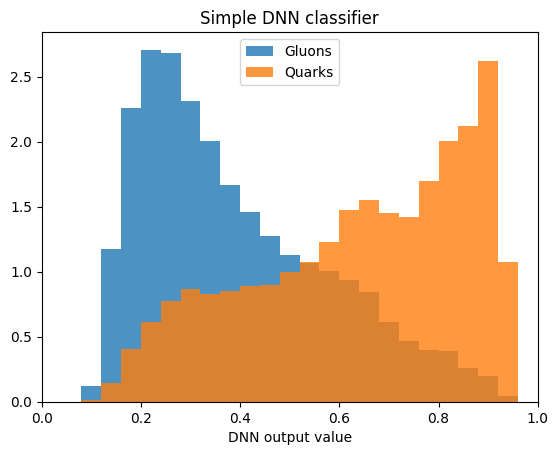

In [27]:
plt.clf()
binnings = np.arange(0.0, 1.0, 0.04)
plt.hist( pred_y[test_y==0], bins=binnings, alpha=0.8, label="Gluons", density=1 )
plt.hist( pred_y[test_y==1], bins=binnings, alpha=0.8, label="Quarks", density=1 )
plt.xlim(0,1)
plt.legend()
plt.xlabel('DNN output value')
plt.title('Simple DNN classifier');

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y, pred_y)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

print(roc_auc_dnn)

0.8005039802847637


Text(0.5, 0, 'Gluon jet acceptance rate')

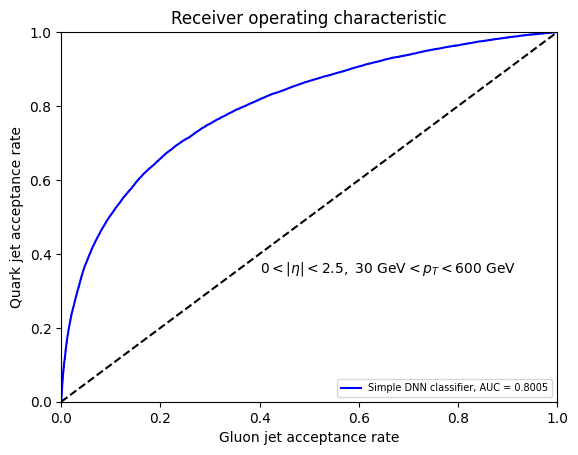

In [29]:
plt.plot(fpr_dnn, tpr_dnn, 'b', label='Simple DNN classifier, AUC = %0.4f'% roc_auc_dnn)
plt.plot([0,1], [0,1], 'k--')
plt.text(0.4, 0.35, '$0<|\eta|<2.5 ,$ $30 $ GeV$<p_T<600 $ GeV', fontsize = 10)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'lower right',prop={'size': 7})
plt.title("Receiver operating characteristic")
plt.ylabel('Quark jet acceptance rate')
plt.xlabel('Gluon jet acceptance rate')